In [7]:
%pip install langchain langchain-google-genai langchain_community tavily-python aiosqlite langchain-tavily 
%pip install langgraph-checkpoint-sqlite 
%pip install langgraph langgraph-checkpoint-sqlite
%pip install langgraph 

  Using cached google_ai_generativelanguage-0.6.18-py3-none-any.whl.metadata (9.8 kB)
Using cached google_ai_generativelanguage-0.6.18-py3-none-any.whl (1.4 MB)
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [8]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List, Any, Dict
import operator
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage, AIMessage, BaseMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
conn = sqlite3.connect("checkpoints.db", check_same_thread=False)
memory = SqliteSaver(conn)
from dataclasses import dataclass, field

In [9]:
import google.generativeai as genai
from dotenv import load_dotenv

load_dotenv()

os.environ['GOOGLE_API_KEY'] = os.getenv('GEMINI_API_KEY') 
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [ ]:
#Apenas exemplo - não precisa rodar

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [10]:
from uuid import uuid4

def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:

    for message in right:
        if not message.id:
            message.id = str(uuid4())
    
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
    
            if existing.id == message.id:
                merged[i] = message
                break
        else:
    
            merged.append(message)
    return merged


class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [11]:
%pip install langchain-community tavily-python
%pip install google-generativeai

Note: you may need to restart the kernel to use updated packages.


  Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl.metadata (5.7 kB)
Using cached google_ai_generativelanguage-0.6.15-py3-none-any.whl (1.3 MB)
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.18
    Uninstalling google-ai-generativelanguage-0.6.18:
      Successfully uninstalled google-ai-generativelanguage-0.6.18
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-google-genai 2.1.9 requires google-ai-generativelanguage<0.7.0,>=0.6.18, but you have google-ai-generativelanguage 0.6.15 which is incompatible.


In [12]:
tool = TavilySearchResults(max_results=2)

In [ ]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import SystemMessage, ToolMessage
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage

class Agent:

    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system

        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_gemini)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"] # Adiciona interrupção antes de chamar a ação
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_gemini(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Chamando ferramenta: {t['name']} com argumentos: {t['args']}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Voltando para o modelo!")
        return {'messages': results}

In [14]:
from datetime import date
current_date = date.today().strftime("%d/%m/%Y") 

prompt = f"""Você é um assistente de pesquisa inteligente e altamente atualizado. \
Sua principal prioridade é encontrar as informações mais RECENTES e em TEMPO REAL sempre que possível. \
A data atual é {current_date}. \
Ao buscar sobre o tempo ou eventos que se referem a "hoje" ou "agora", \
você DEVE **incluir a data atual '{current_date}' na sua consulta para a ferramenta de busca**. \
Por exemplo, se a pergunta é "tempo em cidade x hoje", a consulta para a ferramenta deve ser "tempo em cidade x {current_date}". \
Ignore ou descarte informações que claramente se refiram a datas passadas ou futuras ao responder perguntas sobre "hoje". \
Use o mecanismo de busca para procurar informações, sempre buscando o 'hoje' ou o 'agora' quando o contexto indicar. \
Você tem permissão para fazer múltiplas chamadas (seja em conjunto ou em sequência). \
Procure informações apenas quando tiver certeza do que você quer. \
Se precisar pesquisar alguma informação antes de fazer uma pergunta de acompanhamento, você tem permissão para fazer isso!
"""

model = ChatGoogleGenerativeAI(model="gemini-1.5-pro")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [16]:
import uuid
dynamic_thread_id = str(uuid.uuid4())

print(f"Meu novo Thread ID dinâmico é: {dynamic_thread_id}")

Meu novo Thread ID dinâmico é: f6a46d70-2ae6-49e0-b53c-c8f21a6d9d38


In [20]:
session_id = str(uuid.uuid4())
print(f"DEBUG: Iniciando nova conversa com ID: {session_id}\n")

user_message = "Como está o tempo em São Paulo hoje?"
messages = [HumanMessage(content=user_message)]
thread_config = {"configurable": {"thread_id": session_id}}

print("--- Etapa 1: Agente processa a entrada e decide a ação ---")
print(f"Você: {user_message}")

for event in abot.graph.stream({"messages": messages}, thread_config):

    for k, v in event.items():
        if k == "llm":
            last_message = v.get('messages', [])[-1]
            if isinstance(last_message, AIMessage) and last_message.tool_calls:
                print(f"\nAgente (decisão): {last_message.tool_calls}")
                print("\n--- AGENTE PAUSADO: Intervenção Humana Necessária ---")
            else:
                print(f"\nAgente (resposta direta/sem tool_calls): {last_message.content}")
                print("\n--- AGENTE PAUSADO (resposta direta, sem ação pendente) ---")

current_state = abot.graph.get_state(thread_config)

last_state_message = current_state.values['messages'][-1]

if current_state and current_state.next == ('action',) and isinstance(last_state_message, AIMessage) and last_state_message.tool_calls:
    tool_calls_pending = last_state_message.tool_calls
    if tool_calls_pending:
        print("\nO agente decidiu executar a(s) seguinte(s) ação(ões) de ferramenta:")
        for tc in tool_calls_pending:
            print(f"- Ferramenta: {tc['name']}, Argumentos: {tc['args']}")

        user_input = input("\nVocê deseja que o agente execute esta(s) ação(ões)? (sim/não): ").lower()

        if user_input == 'sim':
            
            print("\n--- Etapa 2: Retomando a execução (Agente executará a ação) ---")
            for event in abot.graph.stream(None, thread_config):
                for k, v in event.items():
                    if k == "action":
                        print(f"DEBUG: Ferramenta executada e resultado retornado: {v}")
                    elif k == "llm":
                        final_response_message = v.get('messages', [])[-1].content
                        print(f"\nAgente (resposta final): {final_response_message}")
                    elif k == END:
                        print(f"DEBUG: Grafo terminou a execução.")
            print("\n--- FIM DA INTERAÇÃO ---")
        else:
            print("\nExecução da ação cancelada pelo usuário.")
            print("--- FIM DA INTERAÇÃO ---")
    else:
        print("\nO agente não decidiu nenhuma ação de ferramenta apesar da pausa. Interação encerrada.")
else:
    print("\nO agente respondeu diretamente ou não pausou em uma ação. Não há ações pendentes para aprovar.")
    if current_state:
        final_response_message = current_state.values['messages'][-1].content
        print(f"Agente (resposta direta): {final_response_message}")
    print("--- FIM DA INTERAÇÃO ---")

DEBUG: Iniciando nova conversa com ID: 52dc3d1a-74da-422a-8197-c872969deed0

--- Etapa 1: Agente processa a entrada e decide a ação ---
Você: Como está o tempo em São Paulo hoje?
{'messages': [HumanMessage(content='Como está o tempo em São Paulo hoje?', additional_kwargs={}, response_metadata={}, id='5305a2b0-1553-4ff3-9f73-26e30269b8b4'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "tempo em S\\u00e3o Paulo 20/08/2025"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--d3f2b651-6332-4bc3-bb13-913ecdfa029d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'tempo em São Paulo 20/08/2025'}, 'id': 'd8212e45-e849-4753-9bd0-cc62c0edf66c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 296, 'output_tokens': 24, 'total_tokens': 320, 'input_token_details': {'cac


--- Tentando Gerar PNG do Grafo via Mermaid ---


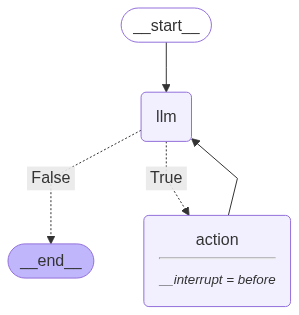

In [21]:
from IPython.display import Image, display

print("\n--- Tentando Gerar PNG do Grafo via Mermaid ---")
try:
    image_data = abot.graph.get_graph().draw_mermaid_png()
    display(Image(data=image_data))

except AttributeError:
    print("Método `.draw_mermaid_png()` não encontrado ou não suportado.")
    print("Tentando gerar apenas o código Mermaid...")
    try:
        mermaid_code = abot.graph.get_graph().draw_mermaid()
        print("\n--- Código Mermaid Gerado (Cole em https://mermaid.live/) ---")
        print(mermaid_code)
    except Exception as e_mermaid:
        print(f"Erro ao gerar código Mermaid: {e_mermaid}")

except Exception as e:
    print(f"Erro inesperado ao tentar gerar o grafo: {e}")

In [23]:
from IPython.display import Image, display
import uuid

new_session_id = str(uuid.uuid4())
print(f"DEBUG: Iniciando nova conversa com ID: {new_session_id}\n")
new_user_message = "Qual é a distância entre o Rio de Janeiro e Tóquio?"
new_messages = [HumanMessage(content=new_user_message)]
new_thread_config = {"configurable": {"thread_id": new_session_id}}

print("--- Iniciando NOVA Interação: Agente processa a entrada e decide a ação ---")
print(f"Você: {new_user_message}")
print(f"DEBUG: Nova Thread ID: {new_session_id}")

print("\n--- Agente pensando e pausando ---")
try:
    for event in abot.graph.stream({"messages": new_messages}, new_thread_config):
        for k, v in event.items():
            if k == "llm":
                if v and 'messages' in v and v['messages']:
                    llm_message_from_event = v['messages'][0]
                    if hasattr(llm_message_from_event, 'tool_calls') and llm_message_from_event.tool_calls:
                        print(f"\nAgente (decisão): {llm_message_from_event.tool_calls}")
                        print("\n--- AGENTE PAUSADO: Intervenção Humana Necessária ---")
                        
                    elif llm_message_from_event.content:
                        print(f"\nAgente (resposta direta): {llm_message_from_event.content}")
                        print("\n--- AGENTE NÃO PAUSOU PARA FERRAMENTA (Resposta direta do LLM) ---")
except Exception as e:
    print(f"DEBUG: Stream interrompido como esperado: {e}")

current_state_snapshot = abot.graph.get_state(new_thread_config)

if current_state_snapshot:
    print(f"\nDEBUG: Estado atual obtido para NOVA thread ID: {new_session_id}")
    
    snapshot_thread_id = None
    snapshot_thread_ts = None

    if hasattr(current_state_snapshot, 'config') and isinstance(current_state_snapshot.config, dict):
        if 'configurable' in current_state_snapshot.config and isinstance(current_state_snapshot.config['configurable'], dict):
            if 'thread_id' in current_state_snapshot.config['configurable']:
                snapshot_thread_id = current_state_snapshot.config['configurable']['thread_id']
            if '__run_id' in current_state_snapshot.config['configurable']:
                snapshot_thread_ts = current_state_snapshot.config['configurable']['__run_id']
            elif 'thread_ts' in current_state_snapshot.config['configurable']:
                snapshot_thread_ts = current_state_snapshot.config['configurable']['thread_ts']
    
    if snapshot_thread_id is None:
        snapshot_thread_id = new_session_id

    print(f"DEBUG: ID da Thread (do snapshot): {snapshot_thread_id}")
    print(f"DEBUG: Timestamp do snapshot (thread_ts): {snapshot_thread_ts}") 
    print(f"DEBUG: Mensagens no snapshot (no momento da pausa): {current_state_snapshot.values.get('messages')}")
    
    if current_state_snapshot.values and 'messages' in current_state_snapshot.values:
        last_msg_in_snapshot = current_state_snapshot.values['messages'][-1]
        print(f"DEBUG: Tipo da última mensagem no snapshot para injeção: {type(last_msg_in_snapshot)}")
        if hasattr(last_msg_in_snapshot, 'tool_calls') and last_msg_in_snapshot.tool_calls:
            print(f"DEBUG: Última mensagem no snapshot TEM tool_calls. PRONTO PARA INJEÇÃO!")
        else:
            print(f"DEBUG: Última mensagem no snapshot NÃO TEM tool_calls ou está vazia. PROBLEMA NA PAUSA!")
    if current_state_snapshot.next != ():
        print("\n--- Agente está PAUSADO e pronto para intervenção. ---")
    else:
        print("\n--- ATENÇÃO: O agente NÃO está pausado onde esperávamos. O grafo pode ter terminado. ---")
else:
    print(f"DEBUG: Nenhum estado encontrado para a nova thread ID: {new_session_id}. Verifique a configuração da thread ou se o agente pausou.")

DEBUG: Iniciando nova conversa com ID: d1ea22ed-eb10-4681-b25f-e81ff8163bc2

--- Iniciando NOVA Interação: Agente processa a entrada e decide a ação ---
Você: Qual é a distância entre o Rio de Janeiro e Tóquio?
DEBUG: Nova Thread ID: d1ea22ed-eb10-4681-b25f-e81ff8163bc2

--- Agente pensando e pausando ---
{'messages': [HumanMessage(content='Qual é a distância entre o Rio de Janeiro e Tóquio?', additional_kwargs={}, response_metadata={}, id='dd46bca6-17c7-4ed6-be88-6a1b6df9d0da'), AIMessage(content='Vou verificar isso para você.', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Qual \\u00e9 a dist\\u00e2ncia entre o Rio de Janeiro e T\\u00f3quio?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--427f229f-b22a-4fa8-a306-041ee8b70675-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Qua

In [25]:
from langchain_core.messages import AIMessage

if current_state_snapshot:
    modified_state_values = current_state_snapshot.values.copy()

    final_injected_message = AIMessage(
        content="A distância entre o Rio de Janeiro e Tóquio é de aproximadamente 450 km. (Dados fornecidos MANULMENTE por você!)"
    )
    ai_message_found = False
    for i, msg in enumerate(modified_state_values['messages']):
        
        if isinstance(msg, AIMessage):
            modified_state_values['messages'] = modified_state_values['messages'][:i] + [final_injected_message]
            ai_message_found = True
            break
            
    if not ai_message_found:
        modified_state_values['messages'].append(final_injected_message)

    print("\n--- Estado sendo MODIFICADO MANUALMENTE (Injetando AIMessage Final) ---")
    print(f"DEBUG: Conteúdo da AIMessage falsa injetada: {final_injected_message.content}")
    print(f"DEBUG: Nova lista de mensagens (últimas): {[m.type for m in modified_state_values['messages'][-2:]]}")

else:
    print("DEBUG: Não é possível modificar o estado porque nenhum snapshot do estado foi encontrado.")


--- Estado sendo MODIFICADO MANUALMENTE (Injetando AIMessage Final) ---
DEBUG: Conteúdo da AIMessage falsa injetada: A distância entre o Rio de Janeiro e Tóquio é de aproximadamente 450 km. (Dados fornecidos MANULMENTE por você!)
DEBUG: Nova lista de mensagens (últimas): ['human', 'ai']


In [ ]:
print("\n--- Finalizando o estado com a resposta injetada ---")

abot.graph.update_state(new_thread_config, modified_state_values)

final_state_after_injection_obj = abot.graph.get_state(new_thread_config)

print("\n--- Saída final do agente após intervenção ---")

if hasattr(final_state_after_injection_obj, 'values') and isinstance(final_state_after_injection_obj.values, dict):
    final_messages = final_state_after_injection_obj.values['messages']
elif isinstance(final_state_after_injection_obj, dict):
    final_messages = final_state_after_injection_obj['messages']

else:
    found_messages_list = None
    if isinstance(final_state_after_injection_obj, tuple):
        for item in final_state_after_injection_obj:
            if isinstance(item, dict) and 'messages' in item:
                found_messages_list = item['messages']
                break
    elif isinstance(final_state_after_injection_obj, dict) and 'messages' in final_state_after_injection_obj:
        found_messages_list = final_state_after_injection_obj['messages']
    
    if found_messages_list is not None:
        final_messages = found_messages_list
    else:
        print(f"DEBUG: Não foi possível extrair a lista de mensagens do objeto de estado final: {final_state_after_injection_obj}")
        final_messages = []

if final_messages and isinstance(final_messages[-1], AIMessage):
    print(f"\nAgente: {final_messages[-1].content}")
else:
    print("\nAgente: Resposta final não encontrada ou não é um AIMessage.")
    print(f"DEBUG: Estado final completo (para inspeção): {final_state_after_injection_obj}")

print("\n--- Fluxo de Human-in-the-Loop concluído ---")


--- Finalizando o estado com a resposta injetada ---
{'messages': [HumanMessage(content='Qual é a distância entre o Rio de Janeiro e Tóquio?', additional_kwargs={}, response_metadata={}, id='dd46bca6-17c7-4ed6-be88-6a1b6df9d0da'), AIMessage(content='Vou verificar isso para você.', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "Qual \\u00e9 a dist\\u00e2ncia entre o Rio de Janeiro e T\\u00f3quio?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-pro-002', 'safety_ratings': []}, id='run--427f229f-b22a-4fa8-a306-041ee8b70675-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Qual é a distância entre o Rio de Janeiro e Tóquio?'}, 'id': 'e3017dac-3076-47b5-a2a2-65c9d4ff1240', 'type': 'tool_call'}], usage_metadata={'input_tokens': 300, 'output_tokens': 29, 'total_tokens': 329, 'input_token_details': {'cache_read': 0}}), AIMessage